# **Experiment Notebook**



In [1]:
# Do not modify this code
!pip install -q utstd

from utstd.ipyrenders import *

In [2]:
# Do not modify this code
import warnings
warnings.simplefilter(action='ignore')

## 0. Import Packages

In [3]:
# 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK



In [4]:
# Import custom package
!pip install my_krml_25552249==2025.0.7.1

---
## A. Project Description


In [5]:
# <Student to fill this section>
student_name = "Shawya Saito"
student_id = "25552249"

In [6]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [7]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

---
## B. Business Understanding

In [8]:
# <Student to fill this section>
business_use_case_description = """
Explain clearly what is the goal of this project for the business.
"""

In [9]:
# Do not modify this code
print_tile(size="h3", key='business_use_case_description', value=business_use_case_description)

In [10]:
# <Student to fill this section>
business_objectives = """
What will be the impact of accurate or incorrect results?
"""

In [11]:
# Do not modify this code
print_tile(size="h3", key='business_objectives', value=business_objectives)

In [12]:
# <Student to fill this section>
stakeholders_expectations_explanations = """
How will the results be used?
Who will be the users of your predictions? Who will be impacted by your predictions?
"""

In [13]:
# Do not modify this code
print_tile(size="h3", key='stakeholders_expectations_explanations', value=stakeholders_expectations_explanations)

---
## C. Data Understanding

### C.1   Load Datasets


In [64]:
# Load training data
X_data = pd.read_csv('../../data/processed/X_data_reg.csv')
y_data = pd.read_csv('../../data/processed/y_data_reg.csv')

# Load test data
X_test = pd.read_csv('../../data/processed/X_test_reg.csv')
y_test = pd.read_csv('../../data/processed/y_test_reg.csv')

Split the data from 2014 onwards

In [65]:
# Make date datetime dtype
X_data['date'] = pd.to_datetime(X_data['date'])

# Filter for more than 2014
mask = X_data['date'].dt.year >= 2014
X_data = X_data[mask]
y_data = y_data[mask]

## D.z Final Selection of Features

In [66]:
# <Student to fill this section>

features_list = selected_features_sfs.tolist()
target = ['precipitation_sum_next_3_days']


In [18]:
X_data = X_data.drop(columns='weather_desc', axis=1)

In [23]:
from my_krml_25552249.features.selection import run_rfe, get_feature_importance
X_data_num = X_data[X_data.select_dtypes(include=['int64', 'float64']).columns.tolist()]
selected_rf_cls, rfe_rf_cls = run_rfe(X_data_num, y_data, model_type="xgb_regressor", n_features_to_select=10)
selected_rf_cls

[INFO] Model: xgb_regressor | Selected 10 features
Selected features: ['precipitation_hours', 'cloud_cover_mean', 'dew_point_2m_min', 'pressure_msl_mean', 'wet_bulb_temperature_2m_min', 'precip_sum_lag2', 'year', 'month_sin', 'sunrise_hour', 'sunset_hour']


['precipitation_hours',
 'cloud_cover_mean',
 'dew_point_2m_min',
 'pressure_msl_mean',
 'wet_bulb_temperature_2m_min',
 'precip_sum_lag2',
 'year',
 'month_sin',
 'sunrise_hour',
 'sunset_hour']

In [25]:
from my_krml_25552249.features.selection import run_rfe, get_feature_importance


In [27]:
feat_imp = get_feature_importance(X_data_num, y_data, model_type="xgb_regressor", top_n=30)
feat_imp

month_sin                      0.117263
cloud_cover_mean               0.084763
quarter                        0.055847
precipitation_hours            0.050227
sunrise_hour                   0.040685
daylight_duration              0.034691
pressure_msl_mean              0.031942
dew_point_2m_min               0.028454
sunset_hour                    0.024528
month_cos                      0.023506
precipitation_sum              0.022766
vapour_pressure_deficit_max    0.021929
cloud_cover_min                0.021428
pressure_msl_min               0.021360
wind_direction_10m_dominant    0.020781
dow_sin                        0.019231
wet_bulb_temperature_2m_max    0.019187
year                           0.017339
pressure_msl_max               0.016799
dew_point_2m_mean              0.016377
apparent_temperature_min       0.016128
temperature_2m_max             0.016052
relative_humidity_2m_mean      0.015673
wind_gusts_10m_min             0.015069
surface_pressure_max           0.014454


In [29]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
import numpy as np

# ---- Step 1: Prepare top features from feat_imp ----
feat_imp_df = feat_imp.reset_index()
feat_imp_df.columns = ["feature", "importance"]
top_n = 30
top_features = feat_imp_df.sort_values(by="importance", ascending=False).head(top_n)["feature"].tolist()
X_top = X_data_num[top_features]

# ---- Step 2: TimeSeriesSplit ----
tscv = TimeSeriesSplit(n_splits=5)

# ---- Step 3: Regression model ----
model_sfs = XGBRegressor(eval_metric='rmse')

# ---- Step 4: RMSE scoring (negate so higher is better for SFS) ----
rmse_scorer = make_scorer(lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)))

# ---- Step 5: Sequential Feature Selector ----
sfs = SequentialFeatureSelector(
    model_sfs,
    n_features_to_select=8,
    direction='forward',
    scoring=rmse_scorer,
    cv=tscv,
    n_jobs=-1
)

# ---- Step 6: Fit SFS ----
sfs.fit(X_top, y_data)

# ---- Step 7: Get selected features ----
selected_features_sfs = X_top.columns[sfs.get_support()]
print("SFS selected features:", selected_features_sfs.tolist())


SFS selected features: ['cloud_cover_mean', 'quarter', 'precipitation_hours', 'pressure_msl_mean', 'pressure_msl_min', 'dow_sin', 'wet_bulb_temperature_2m_max', 'relative_humidity_2m_max']


In [34]:
common = list(set(selected_rf_cls) & set(selected_features_sfs.tolist()))
common

['precipitation_hours', 'pressure_msl_mean', 'cloud_cover_mean']

In [35]:
merge = list(set(selected_rf_cls) | set(selected_features_sfs.tolist()))
merge

['dew_point_2m_min',
 'month_sin',
 'wet_bulb_temperature_2m_min',
 'wet_bulb_temperature_2m_max',
 'pressure_msl_min',
 'sunrise_hour',
 'cloud_cover_mean',
 'quarter',
 'precip_sum_lag2',
 'year',
 'dow_sin',
 'relative_humidity_2m_max',
 'precipitation_hours',
 'pressure_msl_mean',
 'sunset_hour']

In [31]:
# <Student to fill this section>
feature_selection_explanations = """
provide a quick explanation on the features selected
"""

In [32]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_explanations', value=feature_selection_explanations)

---
## E. Data Preparation

### E.1 Data Transformation <put_name_here>

In [33]:
# <Student to fill this section>

In [34]:
# <Student to fill this section>
data_cleaning_1_explanations = """
Provide some explanations on why you believe it is important to fix this issue and its impacts
"""

In [35]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_1_explanations', value=data_cleaning_1_explanations)

---
## F. Feature Engineering

### F.2 New Feature "precipitation sum lag1 and lag2"




In [36]:
# <Student to fill this section>

In [37]:
# <Student to fill this section>
feature_engineering_2_explanations = """
Provide some explanations on why you believe it is important to create this feature and its impacts
"""

In [38]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_2_explanations', value=feature_engineering_2_explanations)

---
## G. Data Preparation for Modeling

### G.1 Split Datasets

Dataset has already been split.

In [67]:
# Select the relevant features
X_data = X_data[features_list]
X_test = X_test[features_list]

In [68]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3652 entries, 1459 to 5110
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cloud_cover_mean             3652 non-null   float64
 1   quarter                      3652 non-null   int64  
 2   precipitation_hours          3652 non-null   float64
 3   pressure_msl_mean            3652 non-null   float64
 4   pressure_msl_min             3652 non-null   float64
 5   dow_sin                      3652 non-null   float64
 6   wet_bulb_temperature_2m_max  3652 non-null   float64
 7   relative_humidity_2m_max     3652 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 256.8 KB


---
## H. Save Datasets

> Do not change this code

In [40]:
# # Do not modify this code
# # Save training set
# try:
#   X_train.to_csv(at.folder_path / 'X_train.csv', index=False)
#   y_train.to_csv(at.folder_path / 'y_train.csv', index=False)

#   X_val.to_csv(at.folder_path / 'X_val.csv', index=False)
#   y_val.to_csv(at.folder_path / 'y_val.csv', index=False)

#   X_test.to_csv(at.folder_path / 'X_test.csv', index=False)
#   y_test.to_csv(at.folder_path / 'y_test.csv', index=False)
# except Exception as e:
#   print(e)

In [41]:
# # Do not modify this code
# # Save training set
# try:
#   X_data.to_csv('../../data/processed/X_data_reg.csv', index=False)
#   y_data.to_csv('../../data/processed/y_data_reg.csv', index=False)

#   X_test.to_csv('../../data/processed/X_test_reg.csv', index=False)
#   y_test.to_csv('../../data/processed/y_test_reg.csv', index=False)
# except Exception as e:
#   print(e)

---
## I. Selection of Performance Metrics

> Provide some explanations on why you believe the performance metrics you chose is appropriate


In [42]:
# RMSE main scoring metric, also look at mae and r^2

In [43]:
# <Student to fill this section>
performance_metrics_explanations = """
Provide some explanations on why you believe the performance metrics you chose is appropriate
"""

In [44]:
# Do not modify this code
print_tile(size="h3", key='performance_metrics_explanations', value=performance_metrics_explanations)

## J. Train Machine Learning Model

### J.1 Import Algorithm

> Provide some explanations on why you believe this algorithm is a good fit


In [45]:
# <Student to fill this section>
algorithm_selection_explanations = """
Provide some explanations on why you believe this algorithm is a good fit
"""

In [46]:
# Do not modify this code
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### J.2 Set Hyperparameters

> Provide some explanations on why you believe this algorithm is a good fit


In [47]:
# <Student to fill this section>

In [39]:
# 


In [69]:
tscv = TimeSeriesSplit(n_splits=5)
space = {
    'max_depth': hp.choice('max_depth', range(2, 10)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'n_estimators': hp.choice('n_estimators', range(50, 500)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
}

In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Objective function
def objective(params):
    rmses = []
    maes = []
    pct_errors = []

    for train_idx, val_idx in tscv.split(X_data):
        X_train, X_val = X_data.iloc[train_idx], X_data.iloc[val_idx]
        y_train, y_val = y_data.iloc[train_idx], y_data.iloc[val_idx]

        model = xgb.XGBRegressor(
            **params,
            random_state=33,
            objective='reg:squarederror',
            tree_method='hist',
            early_stopping_rounds=20,
            n_jobs=-1
        )

        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        preds = model.predict(X_val)
        rmses.append(mean_squared_error(y_val, preds, squared=False))
        maes.append(mean_absolute_error(y_val, preds))

    return {
        'loss': np.mean(rmses),
        'status': STATUS_OK,
        'fold_rmse': rmses,
        'fold_mae': maes,
    }

# Run Hyperopt
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.36trial/s, best loss: 14.394092032718229]


In [71]:
# Best trial index
best_trial_idx = np.argmin([t['result']['loss'] for t in trials.trials])
best_trial = trials.trials[best_trial_idx]

# Fold-wise metrics for best hyperparameters
print("Fold-wise RMSE:", best_trial['result']['fold_rmse'])
print("Mean RMSE:", best_trial['result']['loss'])
print("Fold-wise MAE:", best_trial['result']['fold_mae'])
print("Mean MAE:", np.mean(best_trial['result']['fold_mae']))
print("\n")
# Best hyperparameters
print("Best hyperparameters:", best)

Fold-wise RMSE: [np.float64(14.003967369380304), np.float64(9.226652199495632), np.float64(17.709713432756477), np.float64(17.582628198238524), np.float64(13.447498963720202)]
Mean RMSE: 14.394092032718229
Fold-wise MAE: [np.float64(7.66338601765973), np.float64(6.255088936937912), np.float64(8.244097161694908), np.float64(9.583229878906662), np.float64(7.715148930602139)]
Mean MAE: 7.892190185160271


Best hyperparameters: {'colsample_bytree': np.float64(0.7980559733040726), 'learning_rate': np.float64(0.060842577378308636), 'max_depth': np.int64(0), 'n_estimators': np.int64(133), 'subsample': np.float64(0.6921730750790734)}


In [52]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
Explain why you are tuning these hyperparameters
"""

In [53]:
# Do not modify this code
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.3 Fit Model

In [54]:
# <Student to fill this section>

In [72]:
# Map 'max_depth' choice index back to actual value
max_depth_choices = list(range(2, 10))

final_params = {
    'max_depth': max_depth_choices[int(best['max_depth'])],   # convert index to actual depth
    'n_estimators': int(best['n_estimators']),
    'learning_rate': float(best['learning_rate']),
    'subsample': float(best['subsample']),
    'colsample_bytree': float(best['colsample_bytree']),
    'random_state': 33,                                       
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'n_jobs': -1
}


In [73]:
# Instantiate final model
final_model = xgb.XGBRegressor(**final_params)

# Fit on all training data
final_model.fit(X_data, y_data)

# Predict on test set
y_pred = final_model.predict(X_test)

### J.4 Model Technical Performance

> Provide some explanations on model performance


In [42]:
# <Student to fill this section>

In [74]:
# RMSE
test_rmse = mean_squared_error(y_test, y_pred, squared=False)

# MAE
test_mae = mean_absolute_error(y_test, y_pred)

print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)

Test RMSE: 14.141499042451791
Test MAE: 8.77638678937917


In [46]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("Test R-squared:", r2)

Test R-squared: 0.0866997241973877


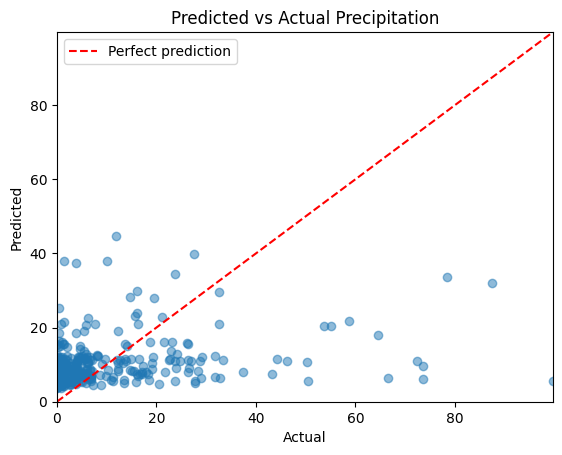

In [48]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual Precipitation")

# Set same limits
min_val = min(np.min(y_test), np.min(y_pred))
max_val = max(np.max(y_test), np.max(y_pred))
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Perfect Prediction
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect prediction')
plt.legend()

plt.show()

In [22]:
y_test_series = y_test.squeeze()  # converts single-column DataFrame to Series

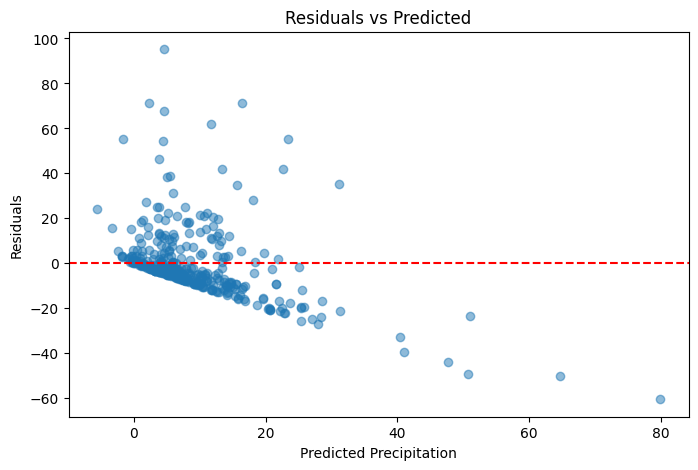

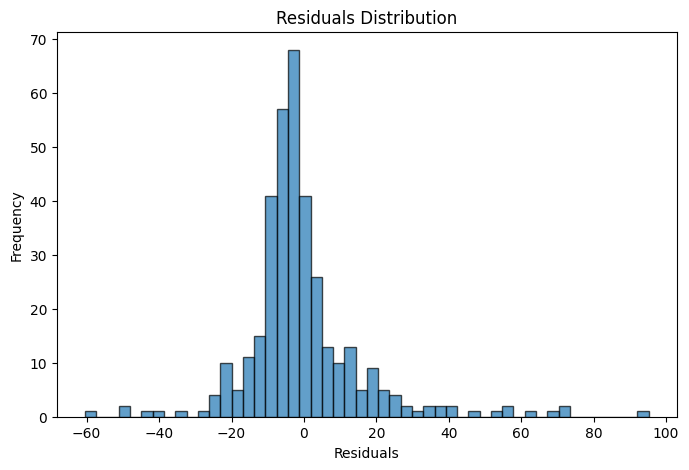

In [23]:
# Calculate residuals
residuals = y_test_series - y_pred

# Scatter plot of residuals vs predicted values
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Precipitation")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

# Histogram of residuals
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.show()

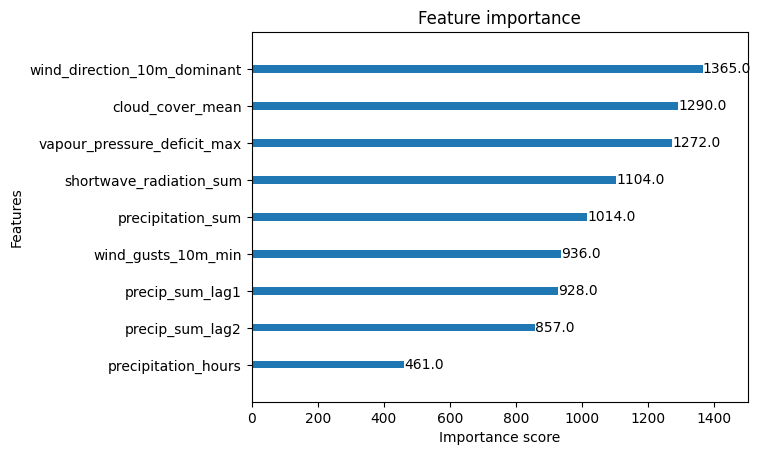

In [24]:
# Plot importances
ax = xgb.plot_importance(final_model)
ax.grid(False)
plt.show()

In [25]:
# Compute mean of training target
train_mean = y_data.mean()

# Predict test set with this mean
y_pred_baseline = np.full_like(y_test, fill_value=train_mean, dtype=np.float64)

# Evaluate
baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)

print("Baseline RMSE on test set:", baseline_rmse)
print("Baseline MAE on test set:", baseline_mae)

Baseline RMSE on test set: 14.741065695171628
Baseline MAE on test set: 9.889686033532463


In [50]:
# <Student to fill this section>
model_performance_explanations = """
Provide some explanations on model performance
"""

In [51]:
# Do not modify this code
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### J.5 Business Impact from Current Model Performance

> Provide some analysis on the model impacts from the business point of view


In [52]:
# <Student to fill this section>

In [53]:
# <Student to fill this section>
business_impacts_explanations = """
Interpret the results of the experiments related to the business objective set earlier. Estimate the impacts of the incorrect results for the business (some results may have more impact compared to others)
"""

In [54]:
# Do not modify this code
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

## H. Project Outcomes

In [55]:
# <Student to fill this section>
experiment_outcome = "" # Either 'Hypothesis Confirmed', 'Hypothesis Partially Confirmed' or 'Hypothesis Rejected'

In [56]:
# Do not modify this code
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_outcome)

In [57]:
# <Student to fill this section>
experiment_results_explanations = """
Reflect on the outcome of the experiment and list the new insights you gained from it. Provide rationale for pursuing more experimentation with the current approach or call out if you think it is a dead end.
Given the results achieved and the overall objective of the project, list the potential next steps and experiments. For each of them assess the expected uplift or gains and rank them accordingly. If the experiment achieved the required outcome for the business, recommend the steps to deploy this solution into production.
"""

In [58]:
# Do not modify this code
print_tile(size="h2", key='experiment_results_explanations', value=experiment_results_explanations)